# Coursework - Fashion-MNIST Classification with ANN and CNN

### 1. Load the Dataset


In [54]:
# Setup - Loading Librabries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [55]:
# For reproducibility
np.random.seed(63)
tf.random.set_seed(63)

In [56]:
# Loading Fashion-MNIST dataset
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('Training set shape:', train_images.shape)
print('Test set shape:', test_images.shape)

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


### 2. Data Preprocessing

In [57]:
# Normalize
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reserve 20% samples from the original training set for validation
val_length = int(0.2 * len(train_images))
val_images = train_images[:val_length]
val_labels = train_labels[:val_length]
train_images = train_images[val_length:]
train_labels = train_labels[val_length:]

print('Training set after split:', train_images.shape)
print('Training label:',train_labels.shape)
print('Validation set:', val_images.shape)
print('Test set:', test_images.shape)

Training set after split: (48000, 28, 28)
Training label: (48000,)
Validation set: (12000, 28, 28)
Test set: (10000, 28, 28)


In [58]:
# One-hot encoded labels for ANN
train_images_ann = train_images.reshape((train_images.shape[0], -1))
val_images_ann = val_images.reshape((val_images.shape[0], -1))
test_images_ann = test_images.reshape((test_images.shape[0], -1))

print('ANN Input dimension:', train_images_ann.shape)

ANN Input dimension: (48000, 784)


In [59]:
train_labels_cat = to_categorical(train_labels, 10)
val_labels_cat = to_categorical(val_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

print("Example encoded label:", train_labels_cat[0])

Example encoded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 3. Model Design

In [60]:
model_ann = models.Sequential([
    layers.Input(shape=(train_images_ann.shape[1],)),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_ann.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,018 (2.18 MB)

 Trainable params: 569,226 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [61]:
# Prepare inputs for the CNN (retain spatial structure)
train_images_cnn = np.expand_dims(train_images, axis=-1)
val_images_cnn = np.expand_dims(val_images, axis=-1)
test_images_cnn = np.expand_dims(test_images, axis=-1)

print('CNN Input dimension:', train_images_cnn.shape)

CNN Input dimension: (48000, 28, 28, 1)


In [62]:
model_cnn = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 158,442 (618.91 KB)

 Trainable params: 157,546 (615.41 KB)

 Non-trainable params: 896 (3.50 KB)

### 4. Training and Testing

In [63]:
# Training ANN model
history = model_ann.fit(
    train_images_ann, train_labels_cat,
    epochs=12,
    batch_size=128,
    validation_data=(val_images_ann, val_labels_cat),
    verbose=2
)

Epoch 1/12
375/375 - 7s - 19ms/step - accuracy: 0.7958 - loss: 0.5840 - val_accuracy: 0.8479 - val_loss: 0.4167
Epoch 2/12
375/375 - 1s - 3ms/step - accuracy: 0.8475 - loss: 0.4193 - val_accuracy: 0.8671 - val_loss: 0.3686
Epoch 3/12
375/375 - 1s - 3ms/step - accuracy: 0.8592 - loss: 0.3844 - val_accuracy: 0.8755 - val_loss: 0.3462
Epoch 4/12
375/375 - 1s - 3ms/step - accuracy: 0.8661 - loss: 0.3619 - val_accuracy: 0.8680 - val_loss: 0.3641
Epoch 5/12
375/375 - 1s - 3ms/step - accuracy: 0.8732 - loss: 0.3432 - val_accuracy: 0.8820 - val_loss: 0.3184
Epoch 6/12
375/375 - 1s - 3ms/step - accuracy: 0.8782 - loss: 0.3303 - val_accuracy: 0.8741 - val_loss: 0.3496
Epoch 7/12
375/375 - 1s - 4ms/step - accuracy: 0.8808 - loss: 0.3168 - val_accuracy: 0.8816 - val_loss: 0.3201
Epoch 8/12
375/375 - 2s - 5ms/step - accuracy: 0.8823 - loss: 0.3127 - val_accuracy: 0.8808 - val_loss: 0.3284
Epoch 9/12
375/375 - 1s - 4ms/step - accuracy: 0.8854 - loss: 0.3063 - val_accuracy: 0.8886 - val_loss: 0.3078


In [64]:
# Train the CNN model
history_cnn = model_cnn.fit(
    train_images_cnn, train_labels_cat,
    epochs=12,
    batch_size=128,
    validation_data=(val_images_cnn, val_labels_cat),
    verbose=2
)

Epoch 1/12
375/375 - 15s - 41ms/step - accuracy: 0.5108 - loss: 1.4362 - val_accuracy: 0.2387 - val_loss: 2.6452
Epoch 2/12
375/375 - 4s - 11ms/step - accuracy: 0.7005 - loss: 0.8420 - val_accuracy: 0.7499 - val_loss: 0.6820
Epoch 3/12
375/375 - 5s - 13ms/step - accuracy: 0.7448 - loss: 0.7057 - val_accuracy: 0.7973 - val_loss: 0.5548
Epoch 4/12
375/375 - 6s - 17ms/step - accuracy: 0.7768 - loss: 0.6189 - val_accuracy: 0.8089 - val_loss: 0.5437
Epoch 5/12
375/375 - 6s - 15ms/step - accuracy: 0.8012 - loss: 0.5558 - val_accuracy: 0.8457 - val_loss: 0.4230
Epoch 6/12
375/375 - 4s - 11ms/step - accuracy: 0.8141 - loss: 0.5190 - val_accuracy: 0.8492 - val_loss: 0.4150
Epoch 7/12
375/375 - 5s - 13ms/step - accuracy: 0.8253 - loss: 0.4849 - val_accuracy: 0.8614 - val_loss: 0.3753
Epoch 8/12
375/375 - 4s - 11ms/step - accuracy: 0.8388 - loss: 0.4547 - val_accuracy: 0.8699 - val_loss: 0.3595
Epoch 9/12
375/375 - 4s - 11ms/step - accuracy: 0.8451 - loss: 0.4348 - val_accuracy: 0.8727 - val_loss

In [65]:
loss_ann, accuracy_ann = model_ann.evaluate(test_images_ann, test_labels_cat, verbose=2)
print("Test accuracy:", accuracy_ann)

313/313 - 2s - 6ms/step - accuracy: 0.8737 - loss: 0.3607
Test accuracy: 0.8737000226974487


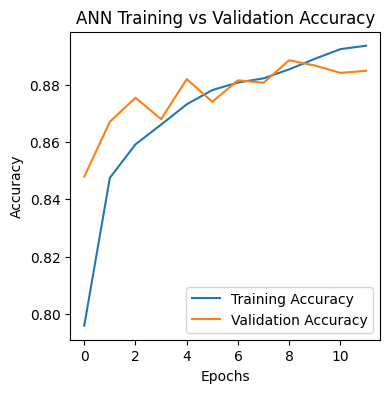

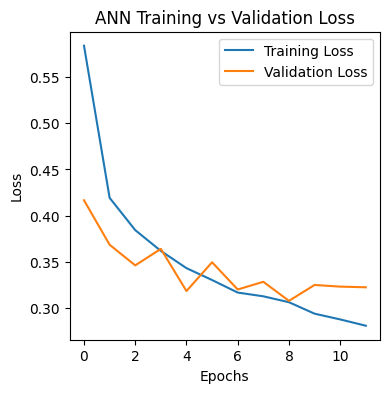

In [66]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


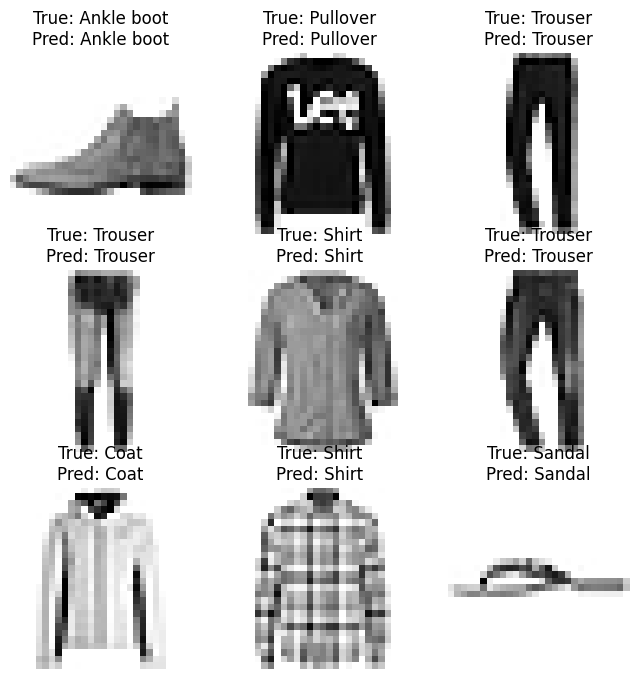

In [67]:
predictions = model_ann.predict(test_images_ann)
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images_ann[i].reshape(28, 28), cmap=plt.cm.binary) # Use binary colormap for grayscale
    plt.title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[np.argmax(predictions[i])]}")
    plt.axis('off')
plt.show()

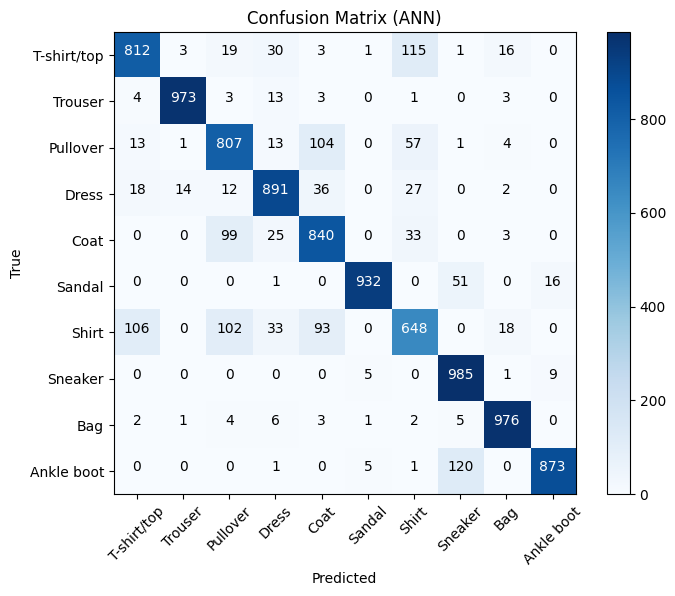


Classification Report (ANN):
               precision    recall  f1-score   support

 T-shirt/top       0.85      0.81      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.77      0.81      0.79      1000
       Dress       0.88      0.89      0.89      1000
        Coat       0.78      0.84      0.81      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.73      0.65      0.69      1000
     Sneaker       0.85      0.98      0.91      1000
         Bag       0.95      0.98      0.96      1000
  Ankle boot       0.97      0.87      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [68]:
# Confusion matrix and classification report for the ANN
y_pred_ann = np.argmax(predictions, axis=1)
conf_matrix_ann = confusion_matrix(test_labels, y_pred_ann)
class_report_ann = classification_report(test_labels, y_pred_ann, target_names=class_names)

# print("Confusion Matrix (ANN):\n", conf_matrix_ann)
# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix_ann, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (ANN)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(conf_matrix_ann.shape[0]):
    for j in range(conf_matrix_ann.shape[1]):
        plt.text(j, i, format(conf_matrix_ann[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_ann[i, j] > conf_matrix_ann.max() / 2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report (ANN):\n", class_report_ann)

313/313 - 2s - 6ms/step - accuracy: 0.8893 - loss: 0.3138
CNN Test accuracy: 0.8892999887466431


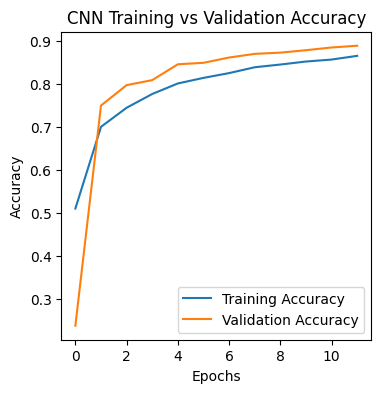

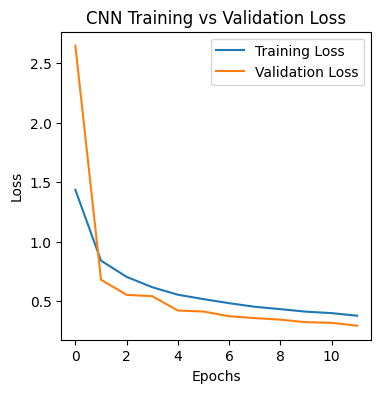

In [69]:
# Evaluate the CNN on the test set
loss_cnn, accuracy_cnn = model_cnn.evaluate(test_images_cnn, test_labels_cat, verbose=2)
print(f"CNN Test accuracy: {accuracy_cnn}")

plt.figure(figsize=(4,4))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


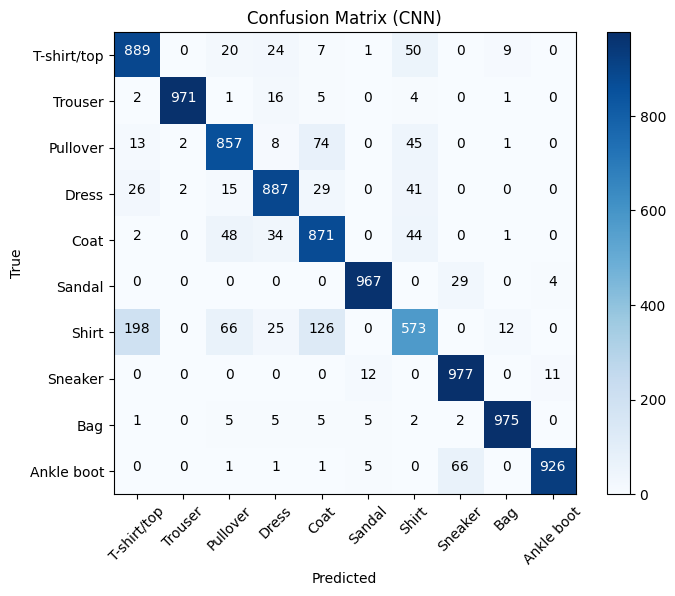


Classification Report (CNN):
               precision    recall  f1-score   support

 T-shirt/top       0.79      0.89      0.83      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.85      0.86      0.85      1000
       Dress       0.89      0.89      0.89      1000
        Coat       0.78      0.87      0.82      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.75      0.57      0.65      1000
     Sneaker       0.91      0.98      0.94      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.98      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [70]:
# Confusion matrix and classification report for the CNN
predictions_cnn = model_cnn.predict(test_images_cnn)
y_pred_cnn = np.argmax(predictions_cnn, axis=1)
conf_matrix_cnn = confusion_matrix(test_labels, y_pred_cnn)
class_report_cnn = classification_report(test_labels, y_pred_cnn, target_names=class_names)

plt.figure(figsize=(8,6))
plt.imshow(conf_matrix_cnn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (CNN)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for i in range(conf_matrix_cnn.shape[0]):
    for j in range(conf_matrix_cnn.shape[1]):
        plt.text(j, i, format(conf_matrix_cnn[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_cnn[i, j] > conf_matrix_cnn.max() / 2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report (CNN):\n", class_report_cnn)

### 5. Analysis and Innovation:


In [71]:
# Compare model performances
print("ANN Test accuracy:", accuracy_ann)
print("CNN Test accuracy:", accuracy_cnn)


ANN Test accuracy: 0.8737000226974487
CNN Test accuracy: 0.8892999887466431


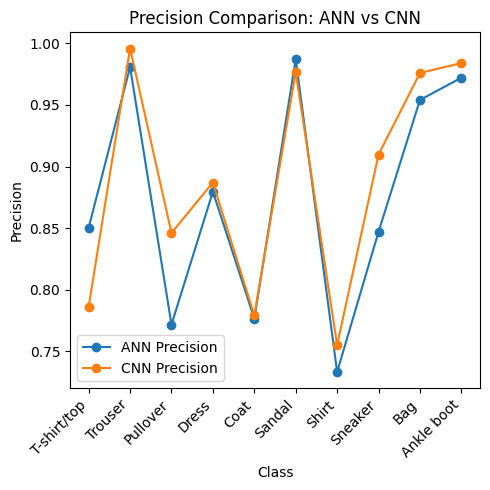

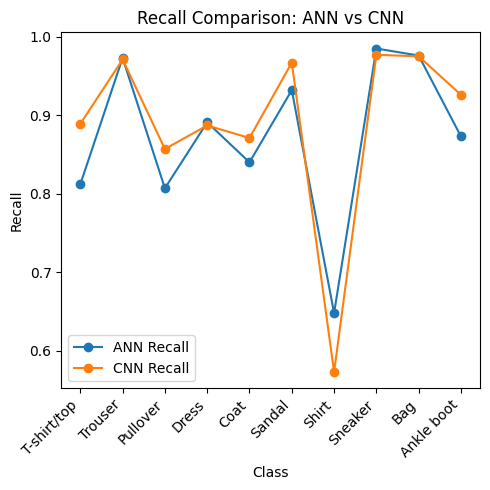

In [72]:
import pandas as pd

# Extract precision and recall from classification reports
report_ann_dict = classification_report(test_labels, y_pred_ann, target_names=class_names, output_dict=True)
report_cnn_dict = classification_report(test_labels, y_pred_cnn, target_names=class_names, output_dict=True)

ann_metrics = pd.DataFrame(report_ann_dict).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
cnn_metrics = pd.DataFrame(report_cnn_dict).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot precision
plt.figure(figsize=(5, 5))
plt.plot(ann_metrics['precision'], marker='o', label='ANN Precision')
plt.plot(cnn_metrics['precision'], marker='o', label='CNN Precision')
plt.xticks(rotation=45, ha='right')
plt.title('Precision Comparison: ANN vs CNN')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

# Plot recall
plt.figure(figsize=(5, 5))
plt.plot(ann_metrics['recall'], marker='o', label='ANN Recall')
plt.plot(cnn_metrics['recall'], marker='o', label='CNN Recall')
plt.xticks(rotation=45, ha='right')
plt.title('Recall Comparison: ANN vs CNN')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend()
plt.tight_layout()
plt.show()

Number of misclassified examples: 1107


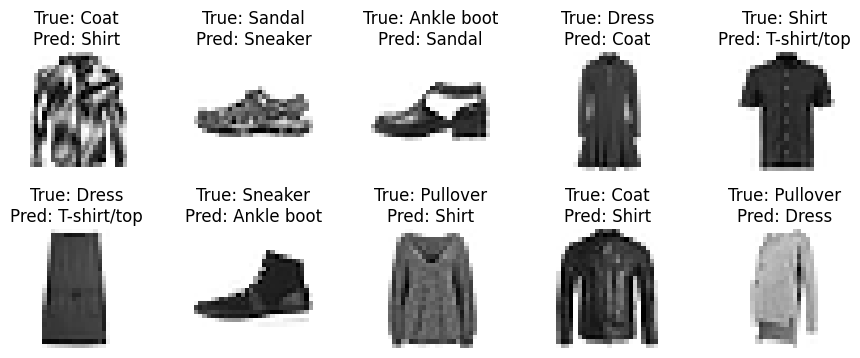

In [73]:
# Misclassified examples for CNN Model
misclassified_indices = np.where(y_pred_cnn != test_labels)[0]
num_misclassified = len(misclassified_indices)
print(f"Number of misclassified examples: {num_misclassified}")

# Display some misclassified examples
plt.figure(figsize=(9,9))
for i in range(min(10, num_misclassified)):
    index = misclassified_indices[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images_cnn[index].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"True: {class_names[test_labels[index]]}\nPred: {class_names[y_pred_cnn[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [74]:
shirt_index = class_names.index('Shirt')
coat_index = class_names.index('Coat')
pullover_index = class_names.index('Pullover')
dress_index = class_names.index('Dress')

data = {
    "Pair": [
        "Shirt → Coat",
        "Coat → Shirt",
        "Pullover → Coat",
        "Coat → Pullover",
        "Dress → Coat",
        "Coat → Dress"
    ],
    "ANN Confusion": [
        conf_matrix_ann[shirt_index, coat_index],
        conf_matrix_ann[coat_index, shirt_index],
        conf_matrix_ann[pullover_index, coat_index],
        conf_matrix_ann[coat_index, pullover_index],
        conf_matrix_ann[dress_index, coat_index],
        conf_matrix_ann[coat_index, dress_index]
    ],
    "CNN Confusion": [
        conf_matrix_cnn[shirt_index, coat_index],
        conf_matrix_cnn[coat_index, shirt_index],
        conf_matrix_cnn[pullover_index, coat_index],
        conf_matrix_cnn[coat_index, pullover_index],
        conf_matrix_cnn[dress_index, coat_index],
        conf_matrix_cnn[coat_index, dress_index]
    ]
}

# Create DataFrame
confusion_df = pd.DataFrame(data)

# Display table
print("\nConfusion Comparison Table (ANN vs CNN):\n")
print(confusion_df.to_string(index=False))


Confusion Comparison Table (ANN vs CNN):

           Pair  ANN Confusion  CNN Confusion
   Shirt → Coat             93            126
   Coat → Shirt             33             44
Pullover → Coat            104             74
Coat → Pullover             99             48
   Dress → Coat             36             29
   Coat → Dress             25             34


**Overall Performance**

| Metric              |     ANN    |     CNN    |
| :------------------ | :--------: | :--------: |
| Training Accuracy   |   0.8937   |   0.8653   |
| Validation Accuracy |   0.8849   | **0.8903** |
| Test Accuracy       |   0.8737   | **0.8893** |
| Training Loss       | **0.2809** |   0.3796   |
| Validation Loss     |   0.3225   | **0.2957** |

Based on the results, the CNN model was able to secure the highest ranking both in testing and validation, 89% etc. The ANN that followed reached 87%. During the process of training, the ANN_Loss was slightly lower, however, the network's performance more closely related to that of the other two sets of data, indicating that the features learned were not specific to the training data, hence there was no overfitting, but rather generalization.


**Training Behavior**

The training and validation curves show that neither of the two models was significantly affected by overfitting. The accuracy and loss values of the ANN remained stable throughout the training and validation process, while the CNN experienced smoothed convergence with closely aligned curves, indicating stable learning. The implementation of Batch Normalization and Dropout layers contributed to the training stability and the prevention of overfitting.


**Confusion Analysis**

The confusion in both models was mainly the same, and they had a hard time with Shirt, Coat, and Pullover, which are very similar to each other visually and texture-wise.

* A high number of Shirts were, in fact, assigned to the wrong classes in the ANN confusion matrix, i.e., misclassification as Coats or Pullover (e.g. 102 coats and 106 shirts misclassified).

* The CNN, although it had an overall accuracy improvement, was still making the same confusion with the three classes. Nevertheless, it was less erroneous with the easier categories like Trousers, Dress, and Sandal, so that was an indication of its knowledge built-up in terms of localized spatial patterns.


**Interpretation**

In summary, the enhanced CNN proved to be the most efficient and effective model over the whole dataset, thus supporting the trend to use convolutional architectures in image data. The ANN was not far off, showing its capacity for good results and stable convergence. The perfect tuning of normalization and the ReLU-based activation are some of the factors that lead to strong performance even in dense networks. Possible future improvements could be, for instance, tuning the learning rates, increasing the depth of the CNN structure, or introducing data augmentation, which could result in the easier classification of visually similar clothing categories, such as Shirt and Coat.